<a href="https://www.kaggle.com/code/mohamedelbadri01/sf-plot-scores?scriptVersionId=210419042" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [34]:
# !pip install numpy pandas xarray xskillscore
# !pip install cdsapi
# !pip install matplotlib cartopy
# !pip install cfgrib
# !pip install ipywidgets
# !jupyter nbextension enable --py --sys-prefix widgetsnbextension
# !pip install seaborn
# !pip install geopandas

<div class="note" style="background-color: lightyellow; color: black; padding: 10px;">
  <h4> Import the Required Libraries </h4>
</div>

In [1]:
import os



import calendar



import xarray as xr



import ipywidgets as widgets



import matplotlib.pyplot as plt



import cartopy.crs as ccrs



import cartopy.feature as cfeature
from IPython.display import display


import numpy as np



import seaborn as sns



import geopandas as gpd

<div class="note" style="background-color: lightyellow; color: black; padding: 10px;">
  <h4> We have Data in separate files, so we downloaded separated files for every period "djf,jja,mam,son", thus to read the data this part contains the required variables. </h4>
</div>

# A-DETERLINISTIC

In [36]:
details="_1993-2016_monthly_mean_11_234_45_-30_-2.5_60"

available_files=["ukmo_602","meteo_france_8","ecmwf_51","eccc_3","eccc_2","dwd_21","cmcc_35"]

VARNAMES = {'tprate': 'tprate',
           't2m':'t2m'}
periods=["djf","mam","jja","son"]

SCOREDIR = "/home/mohamed/EHTPIII/MODELISATION/output/all_scores"

# SCOREDIR = "/home/mohamed/EHTPIII/MODELISATION/output/all_scores/scores_RR/kaggle/working/SF/scores"
config = dict(list_vars=['2m_temperature'], hcstarty=1993, hcendy=2016, start_month=11)
details = "_1993-2016_monthly_mean_5_234_45_-30_-2.5_60"
available_files = ["ukmo_602", "meteo_france_8", "ecmwf_51", "eccc_3", "eccc_2", "dwd_21", "cmcc_35"]
metrics = ["corr", "rsquared", "rmse","corr_pval"]

period_to_month = {
    "djf": 11,
    "mam": 2,
    "jja": 5,
    "son": 8
    }


aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')
fcmonth_slider = widgets.IntSlider(value=4, min=2, max=4, step=1, description='Forecast Month:')
period_dropdown=widgets.Dropdown(options=periods,value="jja",description="period")
var_dropdown=widgets.Dropdown(options=["t2m","RR"],description="variable")
file_dropdown = widgets.Dropdown(options=available_files,description='CENTER')


In [4]:
shapefile_path = '/home/mohamed/EHTPIII/MODELISATION/DATA/Shapefile/shapefile_morocco_world/maroc-world.shp'
shp = gpd.read_file(shapefile_path,encoding='latin1')

## A-1 CORRELATION

In [5]:
def load_data(file_name, aggr, metric,period):

# Get the corresponding month

    mois = period_to_month.get(period)

    file_link = f'{SCOREDIR}/{file_name}_1993-2016_monthly_mean_{mois}_234_45_-30_-2.5_60_{period}.{aggr}.{metric}.nc'

    corr = xr.open_dataset(file_link)

    corr = corr.assign_coords(lon=(((corr.lon + 180) % 360) - 180)).sortby('lon')

    return corr





def plot_corr(file_name, aggr, fcmonth, period):

    config = dict(

        list_vars=['2m_temperature'],

        hcstarty=1993,

        hcendy=2016,

        start_month=period_to_month.get(period),

    )



    origin_labels = {'institution': f'{file_name}', 'metric': "correlation"}

    METR = load_data(file_name, aggr, "corr", period)

    METR_pvalue = load_data(file_name, aggr, "corr_pval", period)



    tit_line1 = '{metric}---'.format(**origin_labels).upper() + " FOR " + file_name.upper()

    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'



    if aggr == '1m':

        validmonth = config['start_month'] + (fcmonth - 1)

        validmonth = validmonth if validmonth <= 12 else validmonth - 12

        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

    elif aggr == '3m':

        validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]

        tit_line2 = tit_line2_base + f' - Valid months: {period}'

    else:

        raise ValueError(f'Unexpected aggregation {aggr}')



    # Select data for the chosen forecast month

    THISMETR = METR.sel(forecastMonth=fcmonth)

    THISMETR_PVAL = METR_pvalue.sel(forecastMonth=fcmonth)



    for var in THISMETR.data_vars:

        fig = plt.figure(figsize=(18, 10))

        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.set_extent([np.nanmin(THISMETR_PVAL[var].lon), np.nanmax(THISMETR_PVAL[var].lon), np.nanmin(THISMETR_PVAL[var].lat), np.nanmax(THISMETR_PVAL[var].lat)], crs=ccrs.PlateCarree())  


        METRVALUES = THISMETR[var].values

        METR_P_VALUES = THISMETR_PVAL[var].values



        if METRVALUES.T.shape == (THISMETR[var].lat.size, THISMETR[var].lon.size):

            METRVALUES = METRVALUES.T

            METR_P_VALUES = METR_P_VALUES.T



        plt.contourf(

            THISMETR[var].lon, THISMETR[var].lat, METRVALUES,

            levels=np.linspace(-1, 1, 30),

            cmap='RdYlBu_r'

        )

        cb = plt.colorbar(shrink=0.5)

        cb.ax.set_ylabel("Correlation", fontsize=12)



        origylim = ax.get_ylim()

        plt.contourf(THISMETR_PVAL[var].lon, THISMETR_PVAL[var].lat, METRVALUES,

                     levels=[0.05, np.inf], hatches=['...', None], colors='none')



        shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)



        if ax.get_ylim() != origylim:

            ax.set_ylim(origylim)



        plt.title(f"{tit_line1} {VARNAMES[var]} (stippling where significance below 95%)\n{tit_line2}", loc='left')

        plt.tight_layout()

        # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/corr/CORR_UNIQUE_{file_name}_{period}.png")

        plt.show()

widgets.interactive(plot_corr,period=period_dropdown,file_name=file_dropdown, aggr=aggr_dropdown, fcmonth=fcmonth_slider)

interactive(children=(Dropdown(description='CENTER', options=('ukmo_602', 'meteo_france_8', 'ecmwf_51', 'eccc_…

In [39]:
# for file_name in available_files:

#     for period in periods:

#         plot_corr(file_name,"3m", 4,period)

<div class="note" style="background-color: lightyellow; color: black; padding: 10px;">
  <h4> in order to have the same color bar range in all plots of the same score, we read all the files and select the minimum and maximum of each metric in all files, then wa use it in the plot . </h4>
</div>

In [6]:
period_to_month = {

    "djf": 11,

    "mam": 2,

    "jja": 5,

    "son": 8

    }


def plot_all_corr(aggr, fcmonth, period):

    config = dict(

        list_vars=['2m_temperature', ],

        hcstarty=1993,

        hcendy=2016,

        start_month=period_to_month.get(period),

    )

    

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols  # Calculate the number of rows needed



    # Determine global min and max for the metric

    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data(file_name, aggr, "corr", period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))

    

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})

    axes = axes.flatten()  # Flatten the axes array for easy iteration



    for i, (ax, file_name) in enumerate(zip(axes, available_files)):

        METR = load_data(file_name, aggr, "corr", period)

        METR_PVAL = load_data(file_name, aggr, "corr_pval", period)

        

        tit_line1 = f"{'CORRELATION'.upper()}:{file_name}"

        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'



        # Determine the valid month(s) for title

        if aggr == '1m':

            validmonth = config['start_month'] + (fcmonth - 1)

            validmonth = validmonth if validmonth <= 12 else validmonth - 12

            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

        elif aggr == '3m':

            validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]

            tit_line2 = tit_line2_base + f' - Valid months: {period}'

        else:

            raise ValueError(f'Unexpected aggregation {aggr}')



        # Select data for the chosen forecast month

        THISMETR = METR.sel(forecastMonth=fcmonth)

        THISMETR_PVAL = METR_PVAL.sel(forecastMonth=fcmonth)



        # Plot each variable for this center

        for var in THISMETR.data_vars:

            METRVALUES = THISMETR[var].values

            METR_P_VALUES = THISMETR_PVAL[var].values

            if METRVALUES.T.shape == (THISMETR[var].lat.size, THISMETR[var].lon.size):

                METRVALUES = METRVALUES.T

                METR_P_VALUES=METR_P_VALUES.T



            im = ax.contourf(

                THISMETR[var].lon, THISMETR[var].lat, METRVALUES,

                levels=np.linspace(global_min, global_max, 30),  # Use global min and max

                cmap='RdYlBu_r'

            )

            ax.set_extent([np.nanmin(THISMETR[var].lon), np.nanmax(THISMETR[var].lon), np.nanmin(THISMETR[var].lat), np.nanmax(THISMETR[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region



            cb = fig.colorbar(im, ax=ax, shrink=0.4)

            cb.ax.set_ylabel("ANOMALY CORRELATION".upper(), fontsize=12)



            shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

            ax.set_title(f"{tit_line1} - {VARNAMES.get(var, var)}\n{tit_line2}", loc='left')





            ax.contourf(THISMETR_PVAL[var].lon, THISMETR_PVAL[var].lat, METR_P_VALUES,levels=[0.05, np.inf], hatches=['...', None], colors='None')





    # Hide any unused subplots

    for j in range(i + 1, len(axes)):

        fig.delaxes(axes[j])



    plt.tight_layout()

    # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/corr/CORR_{period}.png")

    plt.show()


widgets.interactive(plot_all_corr, period=period_dropdown,aggr=aggr_dropdown, fcmonth=fcmonth_slider)

interactive(children=(Dropdown(description='Aggregation:', options=('1m', '3m'), value='1m'), IntSlider(value=…

In [41]:
# for aggr in ["3m"]:

#     for period in periods:

#             for fcmonth in [4]:

#                 plot_all_centers(aggr, fcmonth,period)

## A-2 RMSE-R2

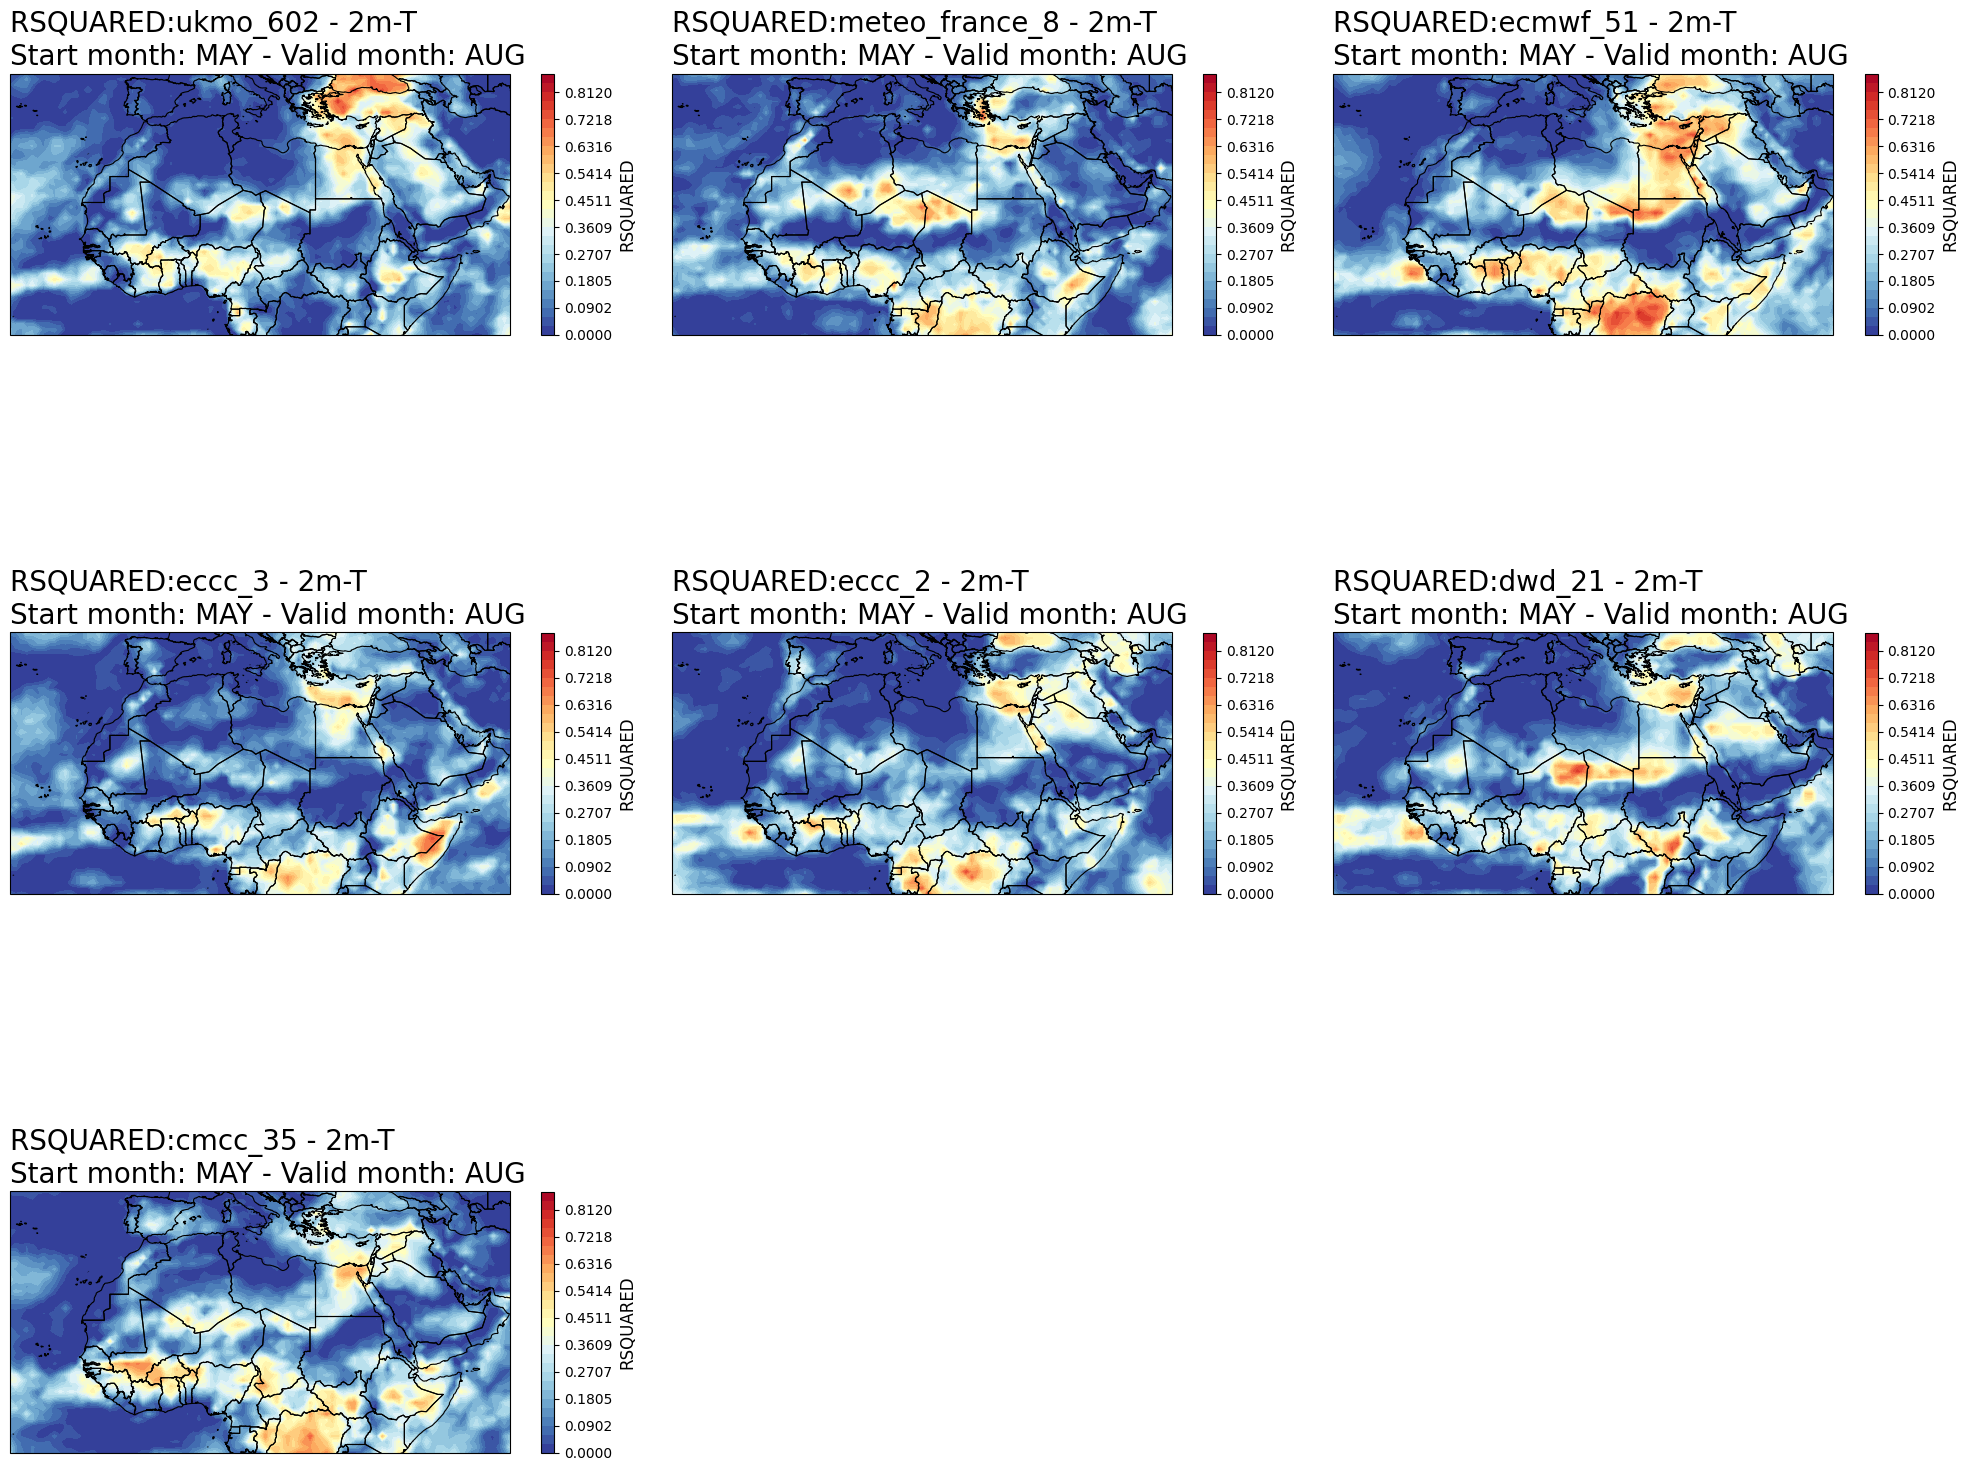

In [42]:
metrics=["rmse","rsquared"]
def plot_all_centers(aggr, fcmonth, metric, period):

    config = dict(

        list_vars=['2m_temperature', ],

        hcstarty=1993,

        hcendy=2016,

        start_month=period_to_month.get(period),

    )

    

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols  # Calculate the number of rows needed



    # Determine global min and max for the metric

    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data(file_name, aggr, metric, period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))

    

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})

    axes = axes.flatten()  # Flatten the axes array for easy iteration



    for i, (ax, file_name) in enumerate(zip(axes, available_files)):

        METR = load_data(file_name, aggr, metric, period)

        tit_line1 = f"{metric.upper()}:{file_name}"

        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'



        # Determine the valid month(s) for title

        if aggr == '1m':

            validmonth = config['start_month'] + (fcmonth - 1)

            validmonth = validmonth if validmonth <= 12 else validmonth - 12

            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

        elif aggr == '3m':

            validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]

            tit_line2 = tit_line2_base + f' - Valid months: {period}'

        else:

            raise ValueError(f'Unexpected aggregation {aggr}')



        # Select data for the chosen forecast month

        THISMETR = METR.sel(forecastMonth=fcmonth)



        # Plot each variable for this center

        for var in THISMETR.data_vars:

            METRVALUES = THISMETR[var].values

            if METRVALUES.T.shape == (THISMETR[var].lat.size, THISMETR[var].lon.size):

                METRVALUES = METRVALUES.T



            im = ax.contourf(

                THISMETR[var].lon, THISMETR[var].lat, METRVALUES,

                levels=np.linspace(global_min, global_max, 30),  # Use global min and max

                cmap='RdYlBu_r'

            )

            ax.set_extent([np.nanmin(THISMETR[var].lon), np.nanmax(THISMETR[var].lon), np.nanmin(THISMETR[var].lat), np.nanmax(THISMETR[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region



            cb = fig.colorbar(im, ax=ax, shrink=0.4)

            cb.ax.set_ylabel(metric.upper(), fontsize=12)



            shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

            ax.set_title(f"{tit_line1} - {VARNAMES.get(var, var)}\n{tit_line2}", loc='left')



    # Hide any unused subplots

    for j in range(i + 1, len(axes)):

        fig.delaxes(axes[j])



    plt.tight_layout()

    # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/{metric}/{metric}_{period}.png")

    plt.show()

metric_dropdown = widgets.Dropdown(options=metrics, value="rsquared", description="Metric")


# Display the interactive plot

widgets.interactive(plot_all_centers, period=period_dropdown,aggr=aggr_dropdown, fcmonth=fcmonth_slider, metric=metric_dropdown)

In [43]:
# for aggr in ["3m"]:

#     for period in periods:

#         for metric in metrics:

#             for fcmonth in [4]:

#                 plot_all_centers(aggr, fcmonth, metric,period)

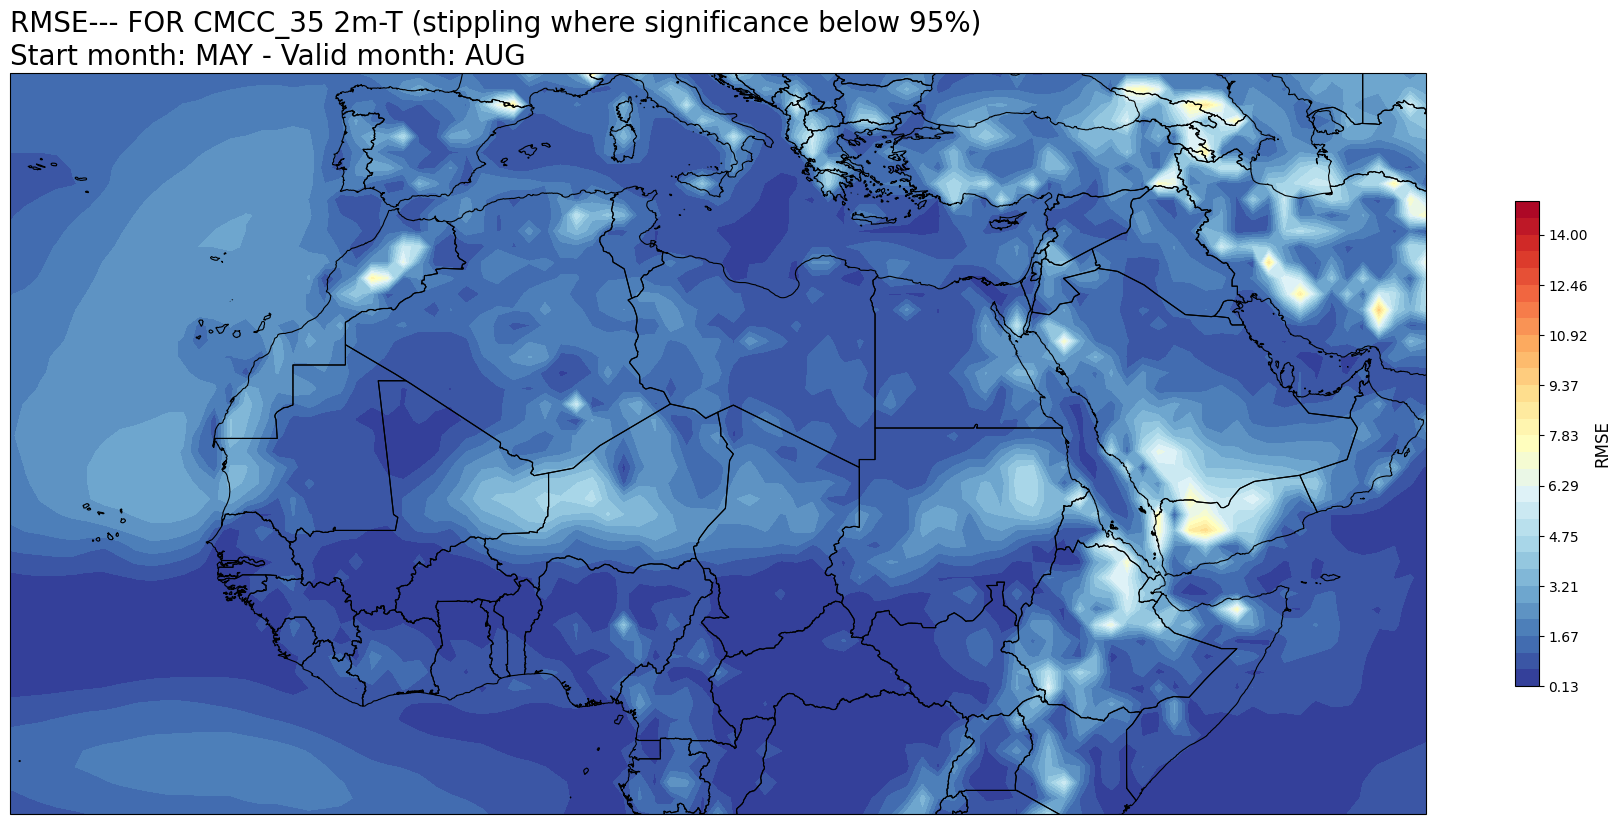

In [44]:
def plot_corr(file_name, aggr, fcmonth,metric,period):

    config = dict(
    list_vars = ['2m_temperature', ],
    hcstarty = 1993,
    hcendy = 2016,
    start_month = period_to_month.get(period))

    
    origin_labels = {'institution': f'{file_name}'
                     ,'metric':f'{metric}'}
    

    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data(file_name, aggr, metric, period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))
            
    METR = load_data(file_name, aggr,metric,period)

    tit_line1='{metric}---'.format(**origin_labels).upper()+" FOR "+file_name.upper()        

    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

    if aggr == '1m':

        validmonth = config['start_month'] + (fcmonth - 1)

        validmonth = validmonth if validmonth <= 12 else validmonth - 12

        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

    elif aggr == '3m':

        validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]

        tit_line2 = tit_line2_base + f' - Valid months: {period.upper()}'

    else:

        raise ValueError(f'Unexpected aggregation {aggr}')


    THISMETR = METR.sel(forecastMonth=fcmonth)


    for var in THISMETR.data_vars:

        fig = plt.figure(figsize=(18, 10))
        
        ax = plt.axes(projection=ccrs.PlateCarree())

        METRVALUES = THISMETR[var].values

        if METRVALUES.T.shape == (THISMETR[var].lat.size, THISMETR[var].lon.size):

            METRVALUES = METRVALUES.T

        plt.contourf(

            THISMETR[var].lon, THISMETR[var].lat, METRVALUES,

            levels=np.linspace(global_min, global_max, 30),

            cmap='RdYlBu_r'

        )

        cb = plt.colorbar(shrink=0.5)

        cb.ax.set_ylabel(metric.upper(), fontsize=12)

        ax.set_extent([np.nanmin(THISMETR[var].lon), np.nanmax(THISMETR[var].lon), np.nanmin(THISMETR[var].lat), np.nanmax(THISMETR[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region

        shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

        origylim = ax.get_ylim()

        if ax.get_ylim() != origylim:

            ax.set_ylim(origylim)

        plt.title(f"{tit_line1} {VARNAMES[var]} (stippling where significance below 95%)\n{tit_line2}", loc='left')

        plt.tight_layout()

        # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/{metric}/{metric}_UNIQUE_{file_name}_{period}.png")

        plt.show()

metric_droptown=widgets.Dropdown(options=metrics,value="rmse",description="Metric")

widgets.interactive(plot_corr,period=period_dropdown, metric=metric_droptown,file_name=file_dropdown, aggr=aggr_dropdown, fcmonth=fcmonth_slider)

In [45]:
# for file_name in available_files:

#         for metric in metrics:

#             for period in periods:

#                     plot_corr(file_name, "3m", 4,metric,period)  

# B-PROBABILISTIC

In [46]:
CATNAMES=['lower tercile', 'middle tercile', 'upper tercile']

plt.rc('axes', titlesize=20)

## B-1 RPS

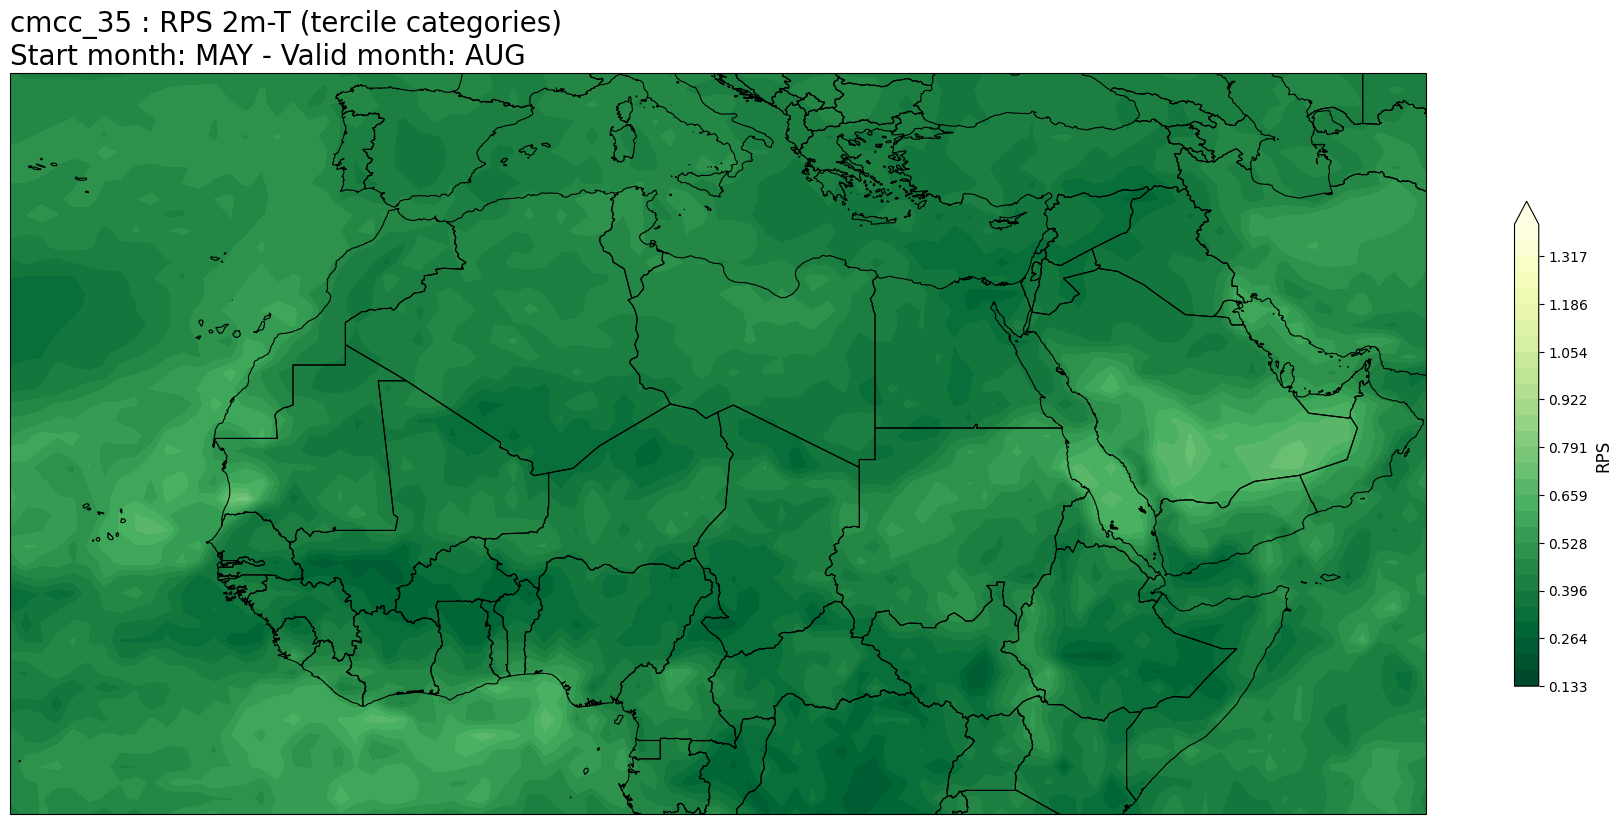

In [47]:
def load_data_proba(file, aggr, metric, period):

    period_to_month = {

        "djf": 11,

        "mam": 2,

        "jja": 5,

        "son": 8
    }

    mois = period_to_month.get(period)

    file_link = f'{SCOREDIR}/{file}_1993-2016_monthly_mean_{mois}_234_45_-30_-2.5_60_{period}.{aggr}.{metric}.nc'

    rps = xr.open_dataset(file_link)

    return rps


def plot_corr(file, aggr, fcmonth, period):

    period_to_month = {

        "djf": 11,

        "mam": 2,

        "jja": 5,

        "son": 8

    }



    config = dict(

        list_vars = ['2m_temperature'],

        hcstarty = 1993,

        hcendy = 2016,

        start_month = period_to_month.get(period),

    )



    origin_labels = {'institution': f'{file}', 'SCORE': "RPS"}





    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data(file_name, aggr, "rps", period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))



    tit_line1 = '{institution} : {SCORE}'.format(**origin_labels)

    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'



    if aggr == '1m':

        validmonth = config['start_month'] + (fcmonth - 1)

        validmonth = validmonth if validmonth <= 12 else validmonth - 12

        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

    elif aggr == '3m':

        validmonths = [vm if vm <= 12 else vm - 12 for vm in [config['start_month'] + (fcmonth - 1) - shift for shift in range(3)]]

        validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]

        tit_line2 = tit_line2_base + f' - Valid months: {period}'

    else:

        raise BaseException(f'Unexpected aggregation {aggr}')

    

    rps = load_data_proba(file, aggr, "rps", period)

    

    # Select data for the chosen forecast month

    thisrps = rps.sel(forecastMonth=fcmonth)

    for var in thisrps.data_vars:

        fig = plt.figure(figsize=(18, 10))

        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.set_extent([np.nanmin(thisrps[var].lon), np.nanmax(thisrps[var].lon), np.nanmin(thisrps[var].lat), np.nanmax(thisrps[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region

        avalues = thisrps[var].values

        cs = plt.contourf(thisrps[var].lon, thisrps[var].lat, avalues, levels=np.linspace(global_min, global_max, 30), cmap='YlGn_r', extend='max')

        cs.cmap.set_under('purple')

        cb = plt.colorbar(shrink=0.5)

        cb.ax.set_ylabel('RPS', fontsize=12)

        shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

        plt.title(tit_line1 + f' {VARNAMES[var]}' + ' (tercile categories)\n' + tit_line2, loc='left')

        plt.tight_layout()  

        # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/rps/rps_UNIQUE_{file_name}_{period}.png")

        plt.show()


widgets.interactive(plot_corr, file=file_droptown, aggr=aggr_dropdown, fcmonth=fcmonth_slider, period=period_dropdown)


In [48]:
# for file_name in available_files:

#     for fcmonth in [2,3,4]:

#         for period in periods:

#             plot_corr(file_name, "3m", 4,period)  

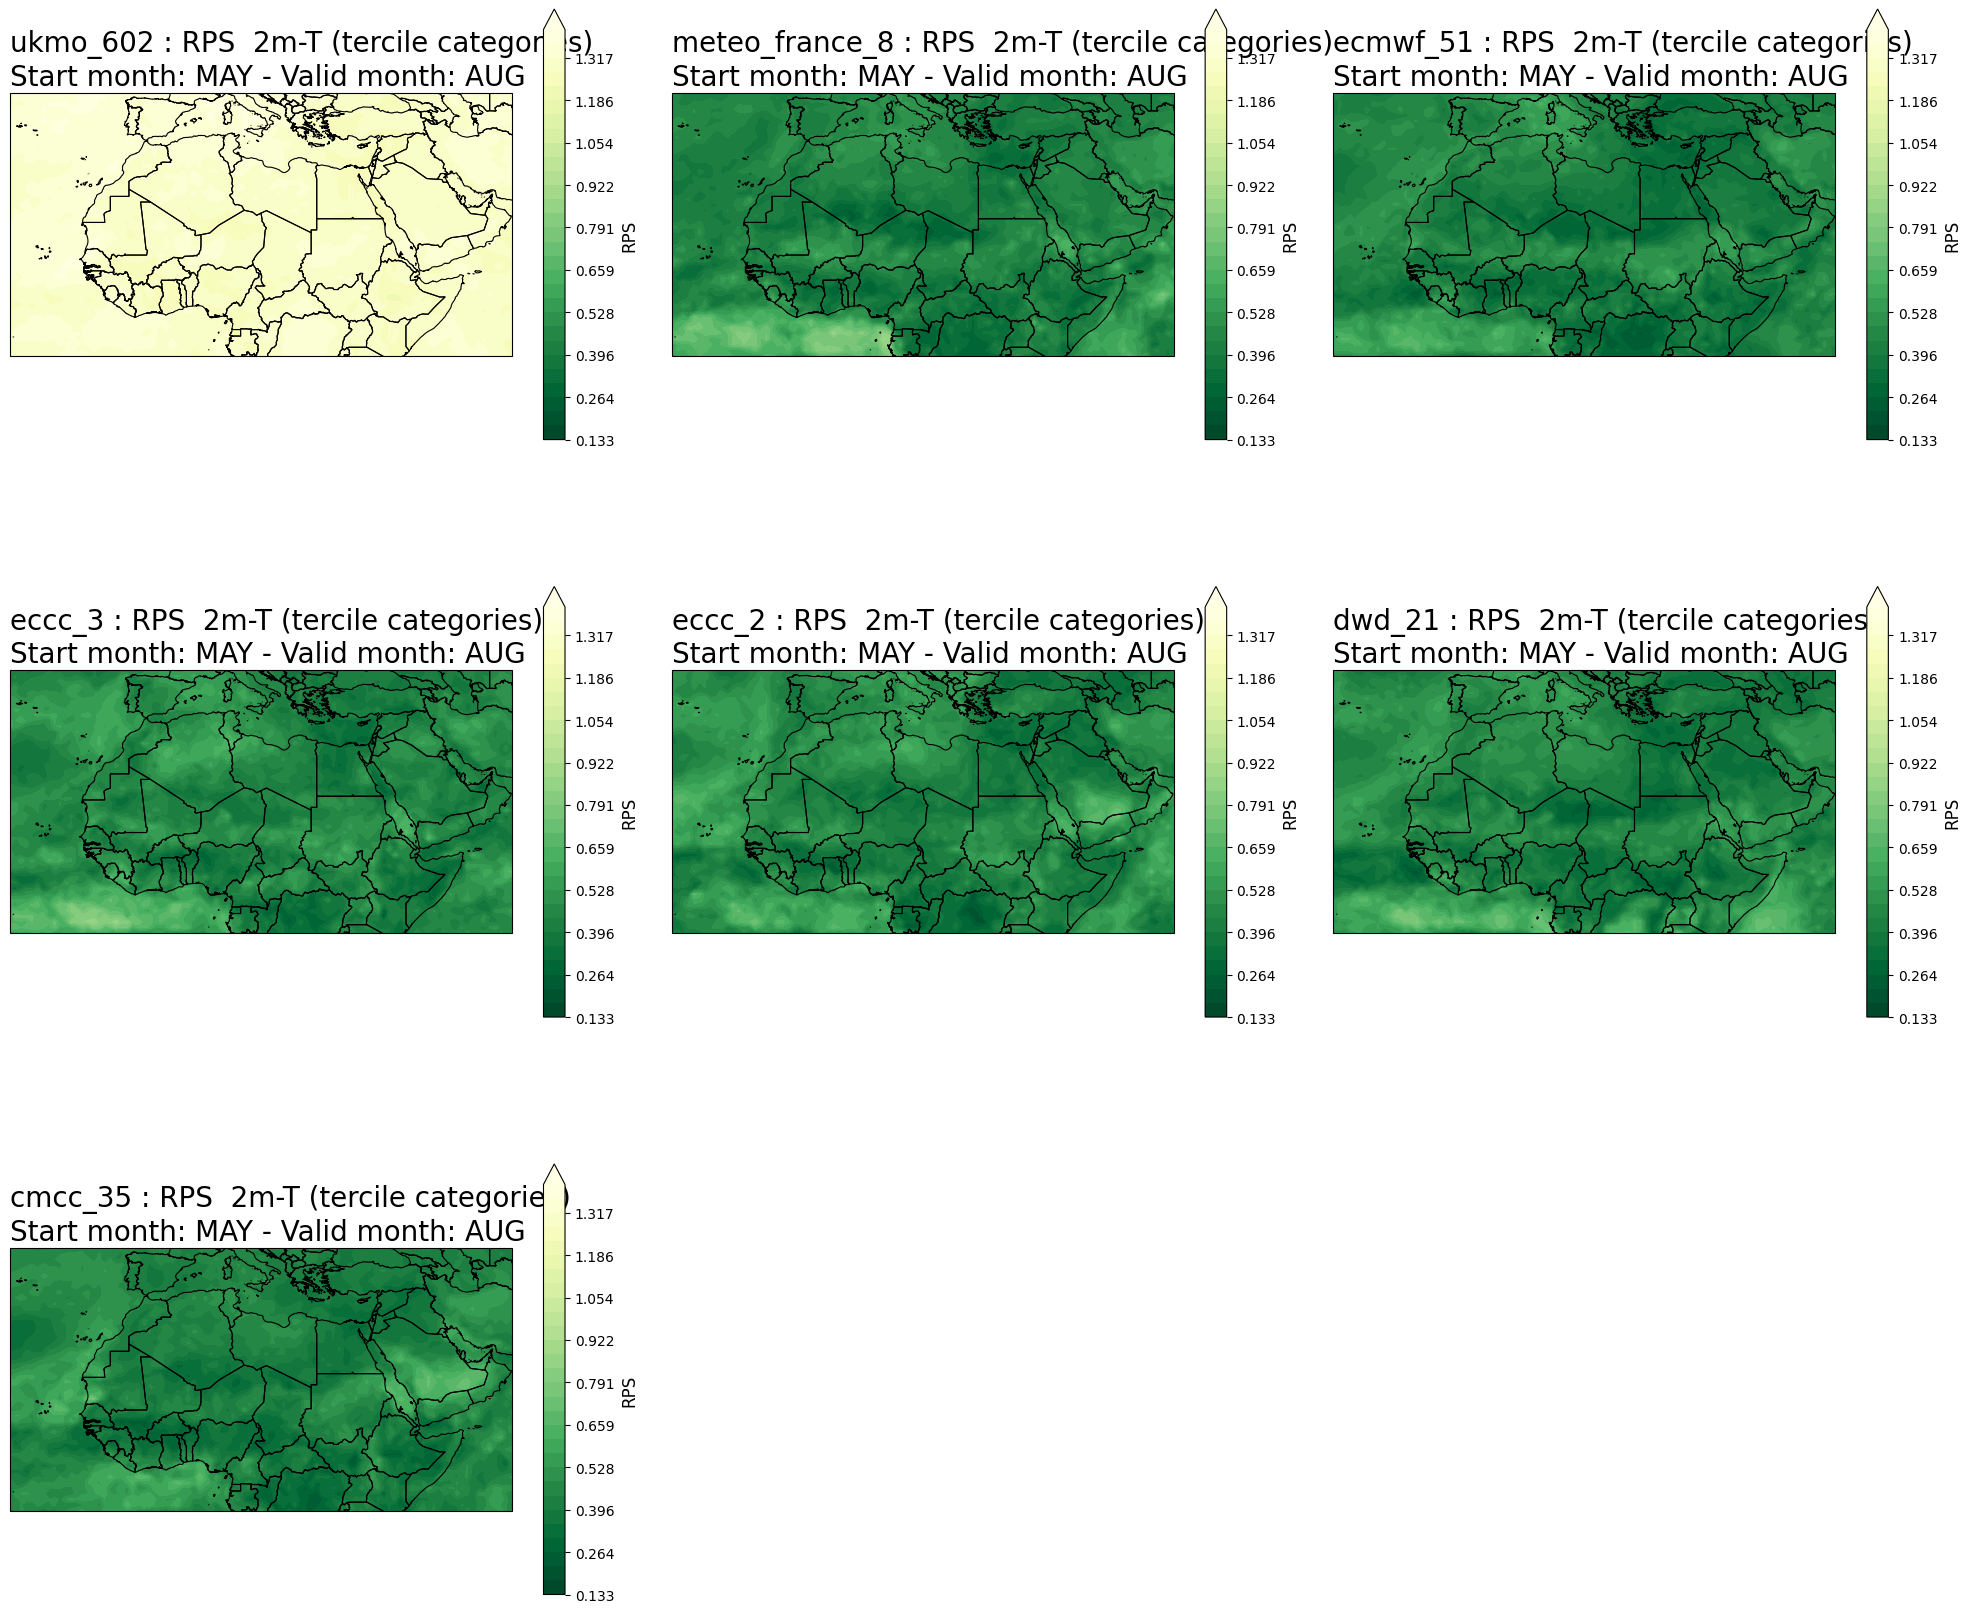

In [49]:
metric="rps"

def plot_rps(aggr, fcmonth, period):

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols



    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})

    axes = axes.flatten()

    config = dict(

        list_vars = ['2m_temperature'],

        hcstarty = 1993,

        hcendy = 2016,

        start_month = period_to_month.get(period),

    )


    for i, center in enumerate(available_files):

        rps = load_data_proba(center, aggr, "rps", period)

        origin_labels = {'institution': f'{center}', 'SCORE':"RPS"}

        # Select data for the chosen forecast month

        thisrps = rps.sel(forecastMonth=fcmonth)


        global_min, global_max = float('inf'), float('-inf')

        for file_name in available_files:

            METR = load_data(file_name, aggr, metric, period)

            for var in METR.data_vars:

                global_min = min(global_min, np.nanmin(METR[var].values))

                global_max = max(global_max, np.nanmax(METR[var].values))



        tit_line1 = '{institution} : {SCORE} '.format(**origin_labels)

        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

    

        if aggr == '1m':

            validmonth = config['start_month'] + (fcmonth-1)

            validmonth = validmonth if validmonth <= 12 else validmonth - 12

            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

        elif aggr == '3m':

            validmonths = [vm if vm <= 12 else vm - 12 for vm in [config['start_month'] + (fcmonth - 1) - shift for shift in range(3)]]

            validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]

            tit_line2 = tit_line2_base + f' - Valid months: {period}'

        else:

            raise BaseException(f'Unexpected aggregation {aggr}')

        for var in thisrps.data_vars:

            ax = axes[i]

            ax.set_extent([np.nanmin(thisrps[var].lon), np.nanmax(thisrps[var].lon), np.nanmin(thisrps[var].lat), np.nanmax(thisrps[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region

            avalues = thisrps[var].values

            cs = ax.contourf(thisrps[var].lon, thisrps[var].lat, avalues, levels=np.linspace(global_min, global_max, 30), cmap='YlGn_r', extend='max')

            cs.cmap.set_under('purple')

            cb = fig.colorbar(cs, ax=ax, shrink=0.7)

            cb.ax.set_ylabel('RPS', fontsize=12)

            ax.set_title(tit_line1 + f' {VARNAMES.get(var, var)}' + ' (tercile categories)\n' + tit_line2, loc='left')

            shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

    for j in range(i + 1, len(axes)):

        fig.delaxes(axes[j])

    plt.tight_layout()

    # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/rps/rps_{period}.png")

    plt.show()

widgets.interactive(plot_rps, aggr=aggr_dropdown, fcmonth=fcmonth_slider, period=period_dropdown)


In [50]:
# for period in periods :

#     plot_rps("3m",4,period)  

## B-2 ROC-ROCSS-BS

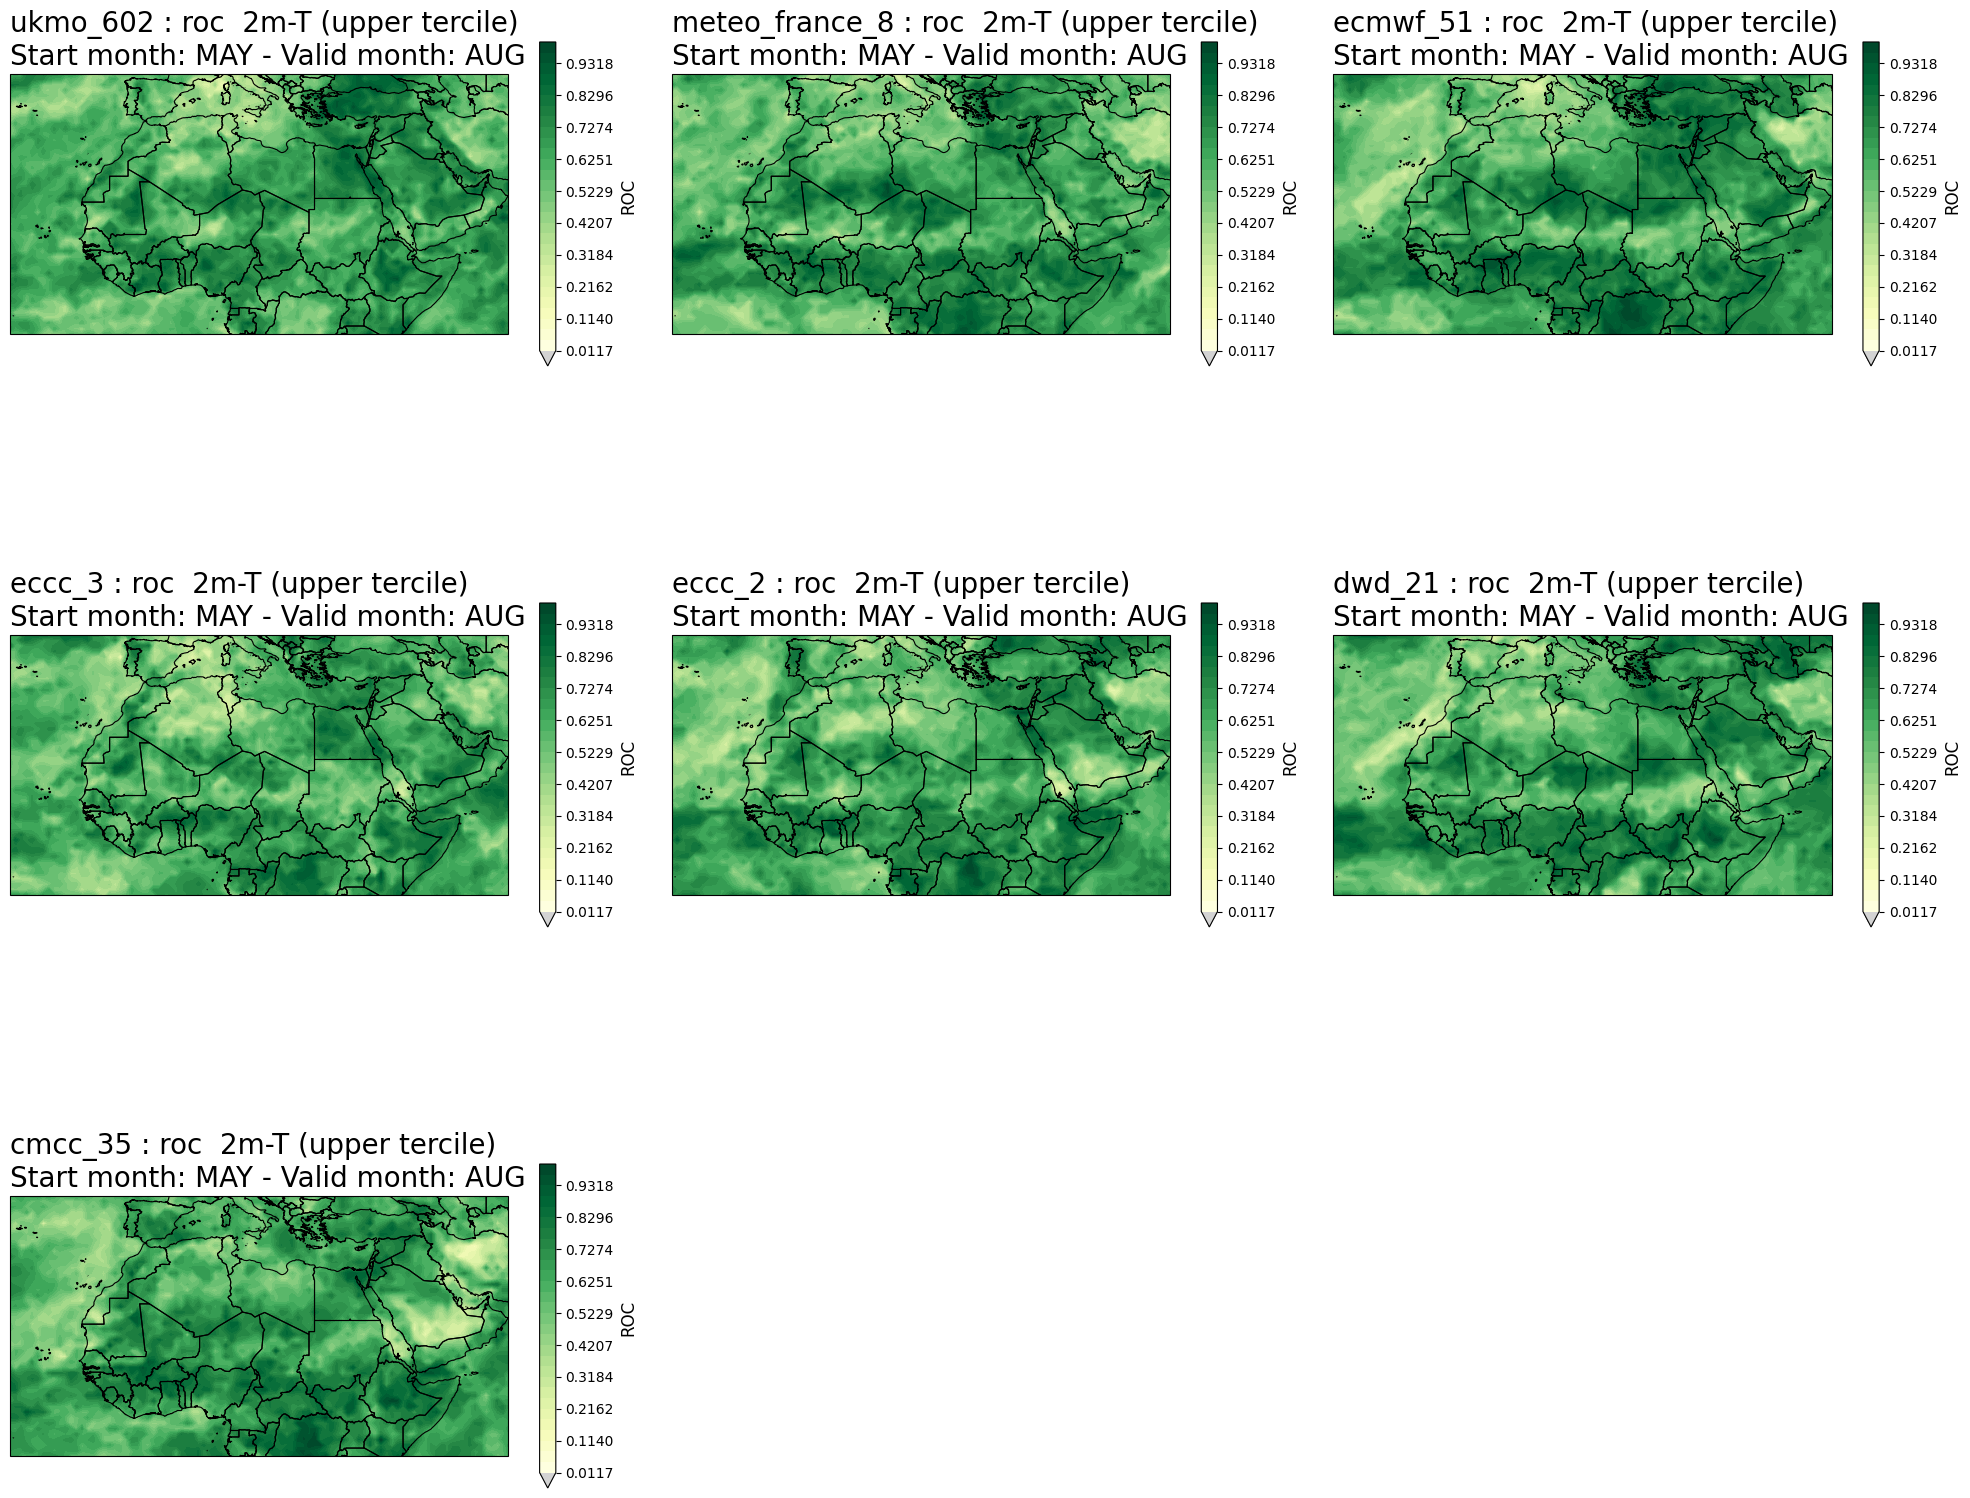

In [51]:
category=["lower","middle","upper"]

def plot_roc(aggr, fcmonth, icat, metric,period):

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})

    axes = axes.flatten()

    config = dict(

    list_vars = ['2m_temperature', ],

    hcstarty = 1993,

    hcendy = 2016,

    start_month = period_to_month.get(period)
    )


    for i in range(n_files):

        origin_labels = {'institution': f'{available_files[i]}', 'SCORE': metric}

        tit_line1 = '{institution} : {SCORE} '.format(**origin_labels)

        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

        if aggr == '1m':

            validmonth = config['start_month'] + (fcmonth - 1)

            validmonth = validmonth if validmonth <= 12 else validmonth - 12

            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

        elif aggr == '3m':

            validmonths = [vm if vm <= 12 else vm - 12 for vm in [config['start_month'] + (fcmonth - 1) - shift for shift in range(3)]]

            validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]

            tit_line2 = tit_line2_base + f' - Valid months: {period}'

        else:

            raise BaseException(f'Unexpected aggregation {aggr}')

        global_min, global_max = float('inf'), float('-inf')

        for file_name in available_files:

            METR = load_data(file_name, aggr, metric, period)

            for var in METR.data_vars:

                global_min = min(global_min, np.nanmin(METR[var].values))

                global_max = max(global_max, np.nanmax(METR[var].values))

        

        roc = load_data_proba(available_files[i], aggr, metric,period)

        thisroc = roc.sel(forecastMonth=fcmonth)

        for var in thisroc.data_vars:

            avalues = thisroc.sel(category=icat)[var].values

            if not np.isnan(avalues).all():

                cs = axes[i].contourf(

                    thisroc[var].lon,

                    thisroc[var].lat,

                    avalues,

                    levels=np.linspace(global_min, global_max, 30),

                    cmap='YlGn', 

                    extend='min'

                )

                cs.cmap.set_under('lightgray')

                cb = fig.colorbar(cs, ax=axes[i], shrink=0.5)

                cb.ax.set_ylabel(metric.upper(), fontsize=12)

            axes[i].set_extent([np.nanmin(thisroc[var].lon), np.nanmax(thisroc[var].lon), np.nanmin(thisroc[var].lat), np.nanmax(thisroc[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region

            shp.plot(ax=axes[i], edgecolor='black', facecolor='none', linewidth=0.8)

            axes[i].set_title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[icat]})\n' + tit_line2, loc='left')

    for j in range(n_files, len(axes)):

        fig.delaxes(axes[j])

    plt.tight_layout()

    # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/{metric}/{metric}_{period}_{category[icat]}.png")

    plt.show()

cat_slider = widgets.IntSlider(value=3, min=0, max=2, step=1, description="cat")

metric_dropdown = widgets.Dropdown(options=["roc", "rocss", "bs"], value="roc", description="Metric")

widgets.interactive(plot_roc, period=period_dropdown,metric=metric_dropdown, aggr=aggr_dropdown, fcmonth=fcmonth_slider, icat=cat_slider)

In [52]:
# metrics=["roc", "rocss", "bs"]

# for metric in metrics:

#     for period in periods :

#         for icat in [0,1,2]:

#             plot_roc("3m", 4,icat,metric,period)  


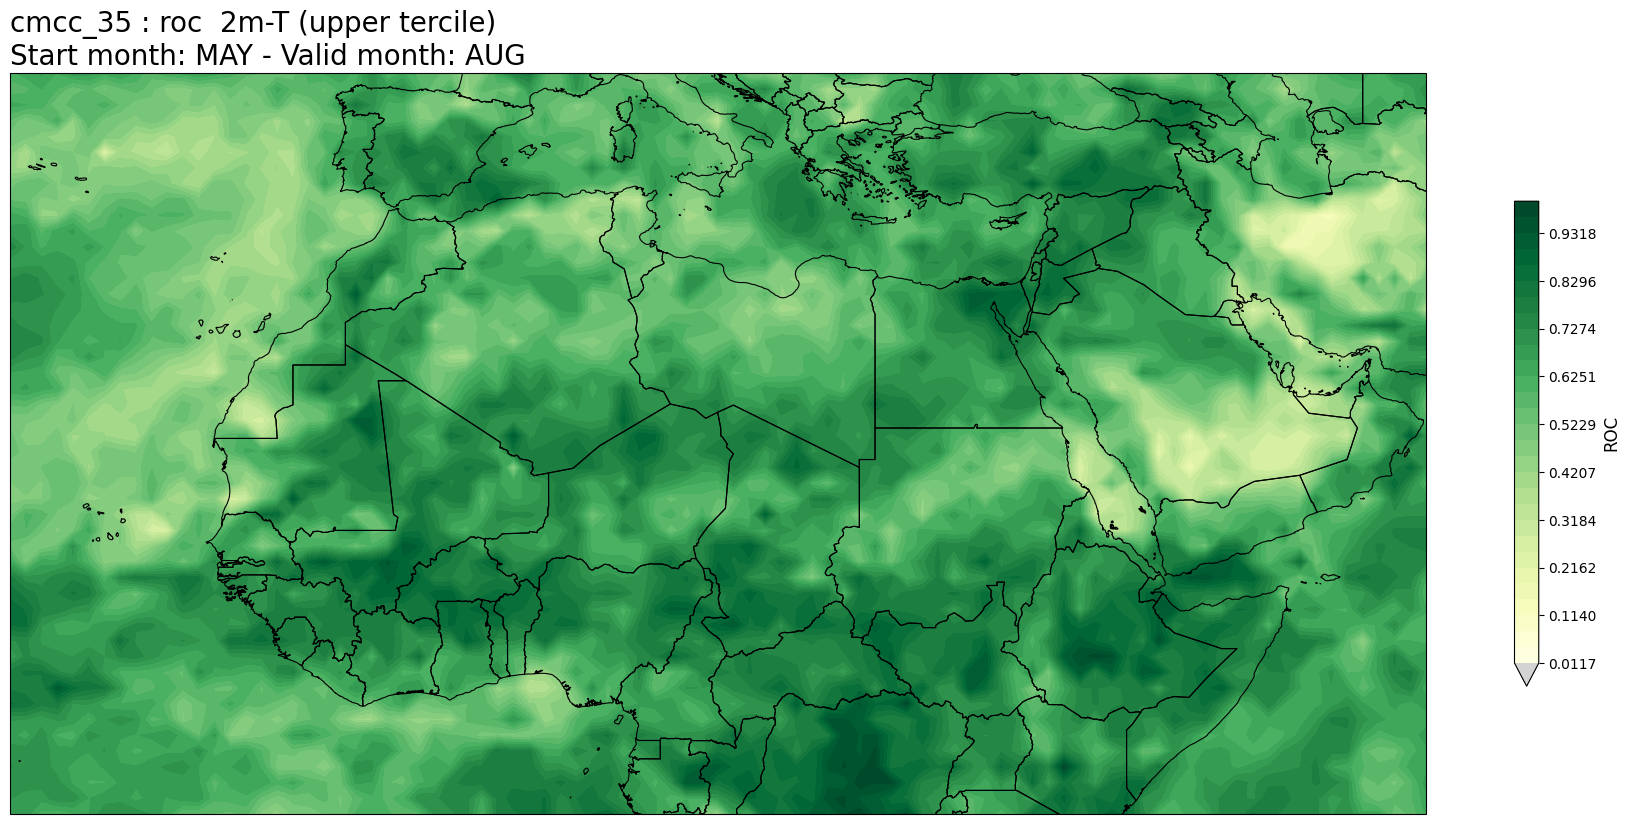

In [53]:
def plot_roc(file,aggr,fcmonth,icat,metric,period):
    
    config = dict(
    list_vars = ['2m_temperature', ],
    hcstarty = 1993,
    hcendy = 2016,
    start_month = period_to_month.get(period))
    origin_labels = {'institution': f'{file}',

                    'SCORE':metric}

    tit_line1 = '{institution} : {SCORE} '.format(**origin_labels)

    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data_proba(file_name, aggr, metric, period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))

    if aggr=='1m':

        validmonth = config['start_month'] + (fcmonth-1)

        validmonth = validmonth if validmonth<=12 else validmonth-12

    #     tit_line2 = tit_line2_base + rf' - Valid month: $\bf{calendar.month_abbr[validmonth].upper()}$'

        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

    elif aggr=='3m':

        validmonths = [vm if vm<=12 else vm-12 for vm in [config['start_month'] + (fcmonth-1) - shift for shift in range(3)]]

        validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]

    #     tit_line2 = tit_line2_base + rf' - Valid months: $\bf{"".join(validmonths)}$'

        tit_line2 = tit_line2_base + f' - Valid months: {period}'

    else:

        raise BaseException(f'Unexpected aggregation {aggr}')

    

    roc=load_data_proba(file,aggr,metric,period)

    thisroc = roc.sel(forecastMonth=fcmonth)

    for var in thisroc.data_vars:

        fig = plt.figure(figsize=(18,10))

        ax = plt.axes(projection=ccrs.PlateCarree())

        avalues = thisroc.sel(category=icat)[var].values

        cs = plt.contourf(thisroc[var].lon,thisroc[var].lat,avalues,levels=np.linspace(global_min, global_max, 30),cmap='YlGn', extend='min')

        cs.cmap.set_under('lightgray')

        cb = plt.colorbar(shrink=0.5)

        cb.ax.set_ylabel(metric.upper(),fontsize=12)

        ax.set_extent([np.nanmin(thisroc[var].lon), np.nanmax(thisroc[var].lon), np.nanmin(thisroc[var].lat), np.nanmax(thisroc[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region

        shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

        plt.title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[icat]})\n' + tit_line2, loc='left')

        plt.tight_layout()  

        # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/{metric}/{metric}_unique_{period}.png")

        plt.show()


cat_slider=widgets.IntSlider(value=3,min=0,max=2,step=1,description="cat")

metric_dropdown=widgets.Dropdown(options=["roc","rocss","bs"],value="roc",description="Metric")

widgets.interactive(plot_roc,period=period_dropdown,metric=metric_dropdown,file=file_droptown,aggr=aggr_droptown,fcmonth=fcmonth_slider,icat=cat_slider)

## B-2 RELIABILITY

/opt/conda/lib/python3.10/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/opt/conda/lib/python3.10/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


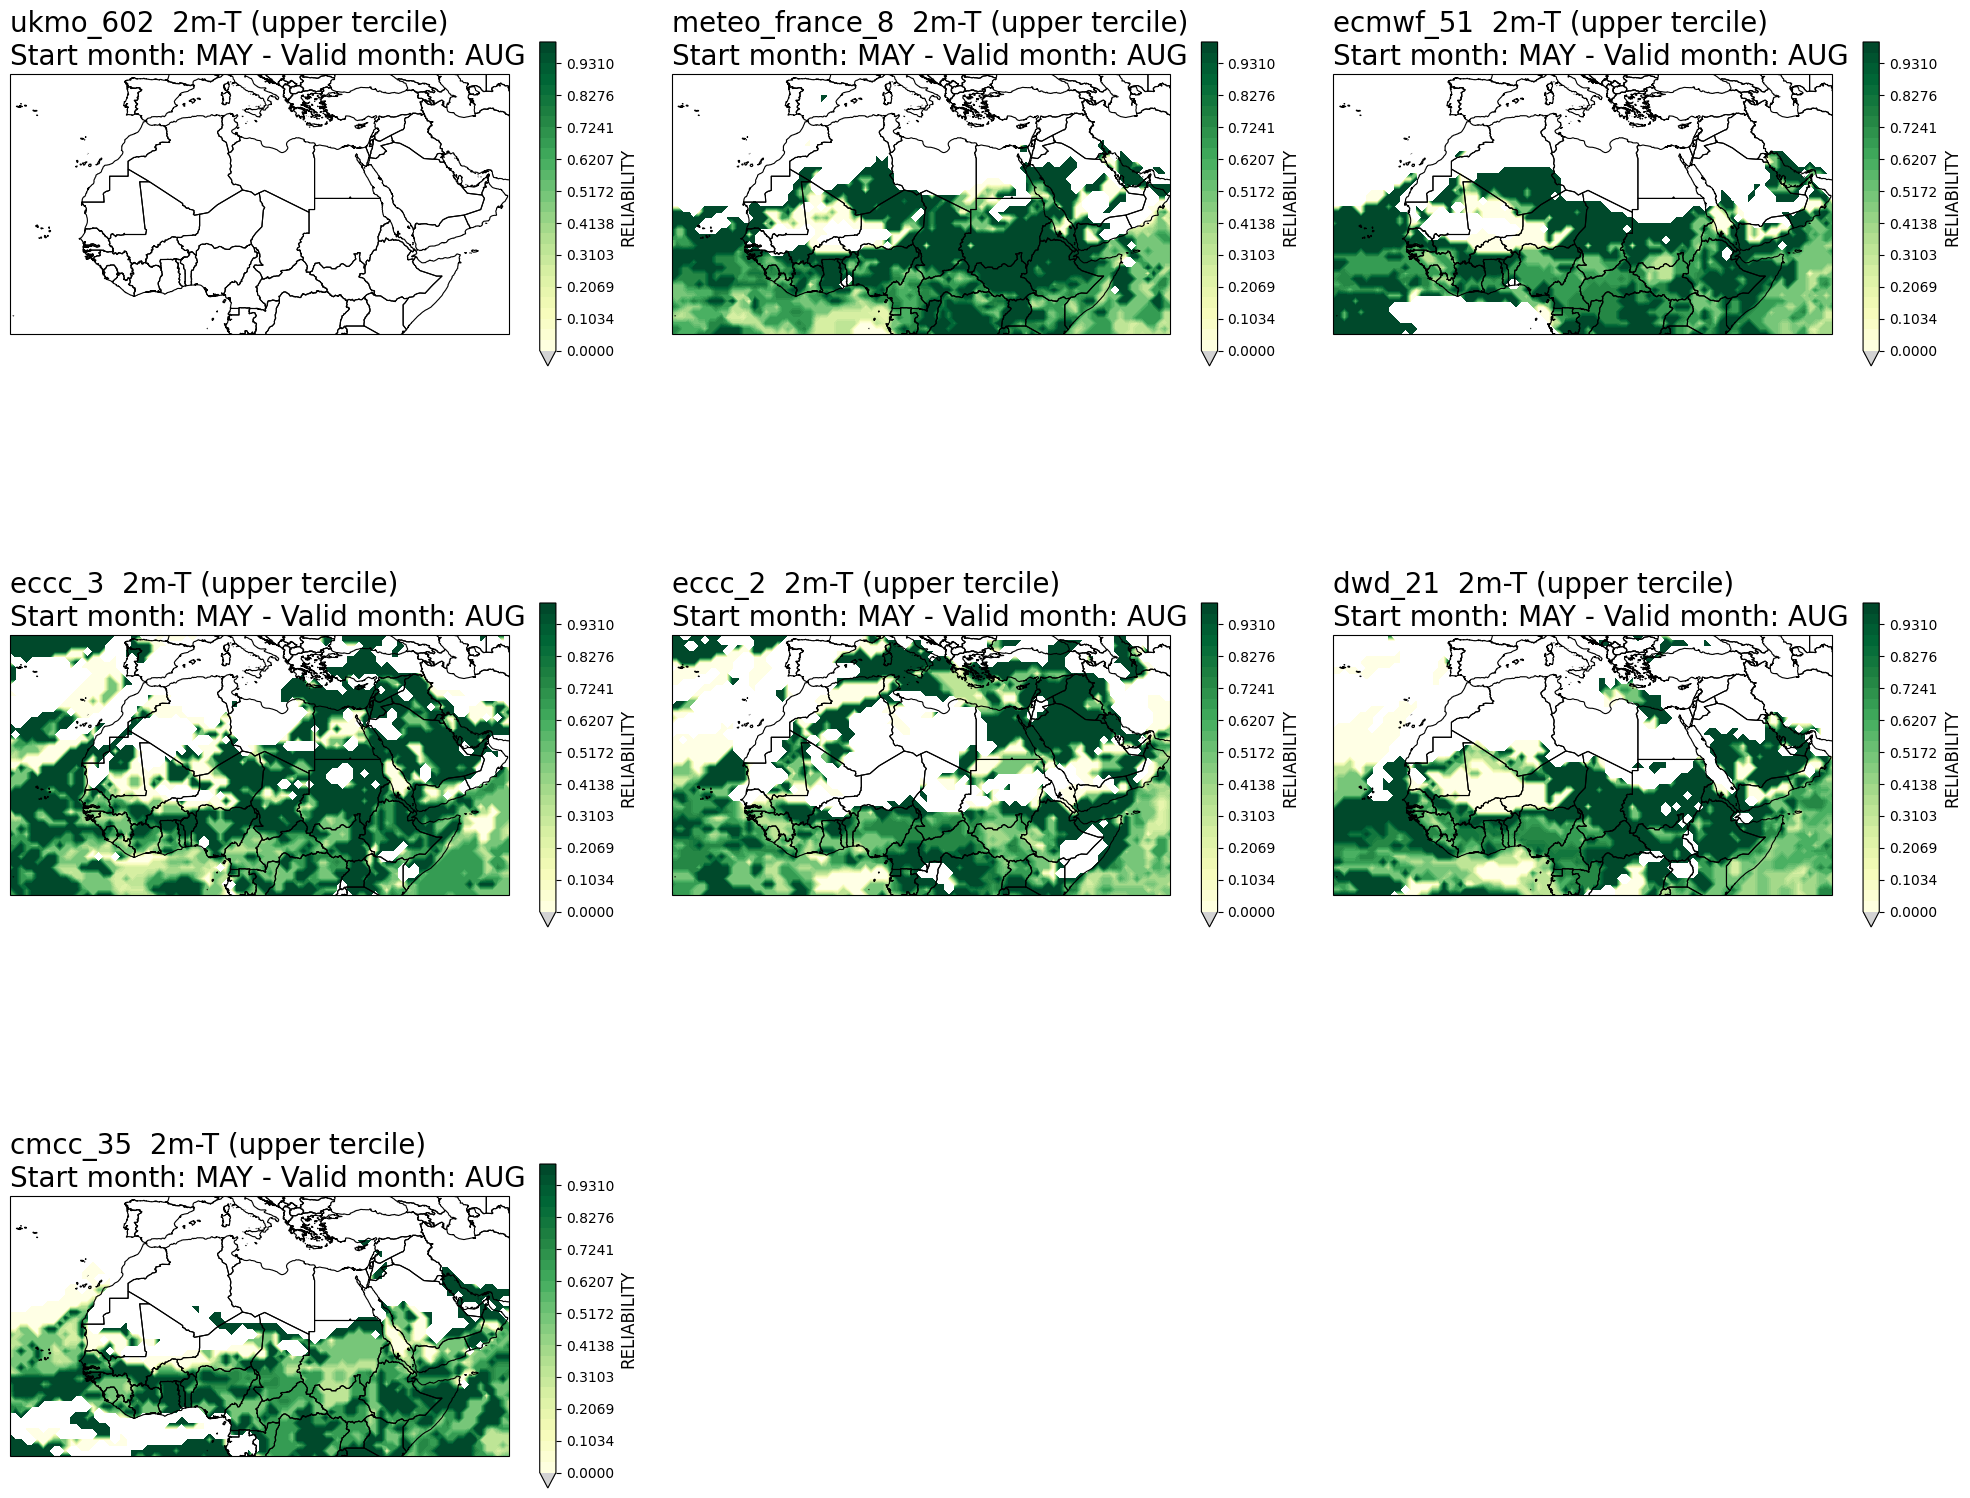

In [54]:
def plot_rela(aggr, fcmonth, cat, forcast_probability, period):
    config = dict(
        list_vars=['2m_temperature'],
        hcstarty=1993,
        hcendy=2016,
        start_month=period_to_month.get(period)
    )

    metric = "rela"
    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:
        METR = load_data_proba(file_name, aggr, metric, period)

        for var in METR.data_vars:
            global_min = min(global_min, np.nanmin(METR[var].values))
            global_max = max(global_max, np.nanmax(METR[var].values))

    n_files = len(available_files)
    n_cols = 3
    n_rows = (n_files + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()

    for i in range(len(available_files)):
        center = available_files[i]
        metric = "rela"
        rela = load_data_proba(available_files[i], aggr, metric, period)
        thisrela = rela.sel(forecastMonth=fcmonth)
        origin_labels = {"institution": center}
        tit_line1 = '{institution} '.format(**origin_labels)
        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

        if aggr == '1m':
            validmonth = config['start_month'] + (fcmonth - 1)
            validmonth = validmonth if validmonth <= 12 else validmonth - 12
            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

        elif aggr == '3m':
            validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]
            tit_line2 = tit_line2_base + f' - Valid months: {period}'
        else:
            raise ValueError(f'Unexpected aggregation {aggr}')

        for var in thisrela.data_vars:
            try:
                # Ensure valid data selection
                avalues = thisrela.sel(
                    category=cat,
                    forecast_probability=forcast_probability,
                    method='nearest'
                )[var].values

                # Mask NaN values to prevent plotting issues
                avalues = np.where(np.isnan(avalues), np.nan, avalues)

                cs = axes[i].contourf(
                    thisrela[var].lon, thisrela[var].lat, avalues,
                    levels=np.linspace(global_min, global_max, 30),
                    cmap='YlGn', extend='min'
                )
                cs.cmap.set_under('lightgray')
                cb = fig.colorbar(cs, ax=axes[i], shrink=0.5)
                cb.ax.set_ylabel('RELIABILITY', fontsize=12)

                axes[i].set_extent(
                    [np.nanmin(thisrela[var].lon), np.nanmax(thisrela[var].lon),
                     np.nanmin(thisrela[var].lat), np.nanmax(thisrela[var].lat)],
                    crs=ccrs.PlateCarree()
                )

                shp.plot(ax=axes[i], edgecolor='black', facecolor='none', linewidth=0.8)

                axes[i].set_title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[cat]})\n' + tit_line2, loc='left')

            except Exception as e:
                print(f"Error plotting for variable '{var}': {e}")

    for j in range(n_files, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


cat_slider=widgets.IntSlider(value=3,min=0,max=2,step=1,description="cat")

forcast_probability_slider=widgets.FloatSlider(value=10,min=0.1,max=0.9,step=0.2,description="forcast probability")

widgets.interactive(plot_rela,period=period_dropdown,aggr=aggr_droptown,fcmonth=fcmonth_slider,cat=cat_slider,forcast_probability=forcast_probability_slider)

Shape of avalues: t2m


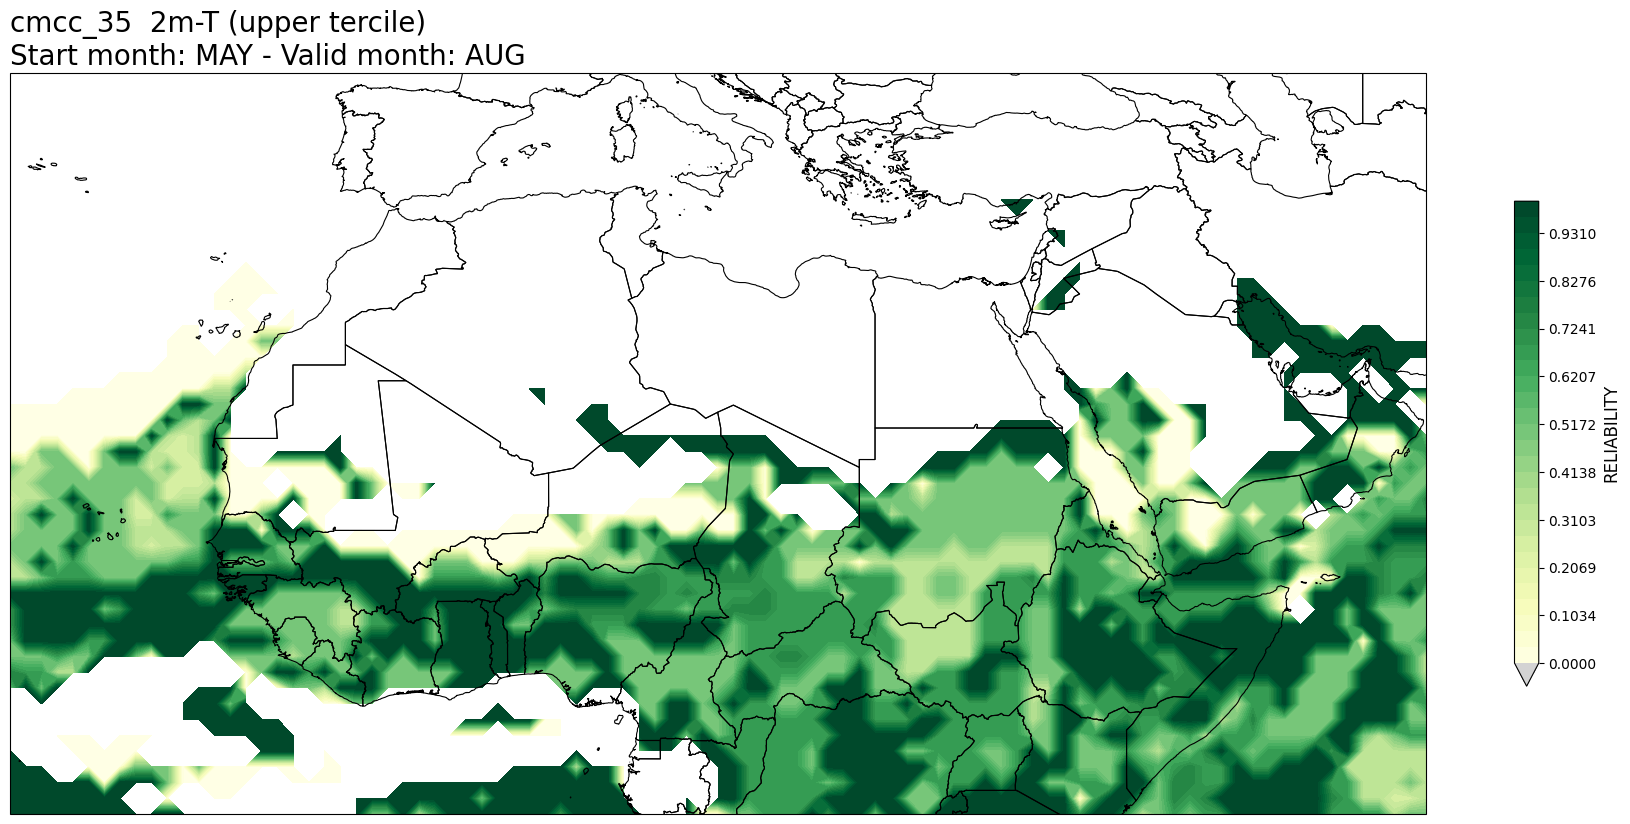

In [55]:
def plot_rela(center,aggr,fcmonth,cat,forcast_probability,period):

    config = dict(

    list_vars = ['2m_temperature', ],

    hcstarty = 1993,

    hcendy = 2016,

    start_month = period_to_month.get(period))
    metric="rela"

    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data_proba(file_name, aggr, metric, period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))    

    rela=load_data_proba(center, aggr, metric,period)

    thisrela = rela.sel(forecastMonth=fcmonth)

    origin_labels={"institution" : center}

    tit_line1 = '{institution} '.format(**origin_labels)

    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

    if aggr == '1m':

        validmonth = config['start_month'] + (fcmonth - 1)

        validmonth = validmonth if validmonth <= 12 else validmonth - 12

        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

    elif aggr == '3m':

        validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]

        tit_line2 = tit_line2_base + f' - Valid months: {period}'

    else:

        raise ValueError(f'Unexpected aggregation {aggr}')

    for var in thisrela.data_vars:



        fig = plt.figure(figsize=(18,10))



        ax = plt.axes(projection=ccrs.PlateCarree())



        avalues = thisrela.sel(category=cat,forecast_probability=forcast_probability,method='nearest')[var].values



        print("Shape of avalues:", var)



        # cs = plt.contourf(thisrela[var].lon,thisrela[var].lat,avalues,levels=np.linspace(0.5,1.,6),cmap='YlGn', extend='min')

        cs = plt.contourf(thisrela[var].lon,thisrela[var].lat,avalues,levels=np.linspace(global_min, global_max, 30),cmap='YlGn', extend='min')

        cs.cmap.set_under('lightgray')

        cb = plt.colorbar(shrink=0.5)

        cb.ax.set_ylabel('RELIABILITY',fontsize=12)

        plt.title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[cat]})\n' + tit_line2, loc='left')

        shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

        ax.set_extent([np.nanmin(thisrela[var].lon), np.nanmax(thisrela[var].lon), np.nanmin(thisrela[var].lat), np.nanmax(thisrela[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region

        plt.tight_layout()  

        # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/rela/rela_unique_{period}.png")

        plt.show()

cat_slider=widgets.IntSlider(value=3,min=0,max=2,step=1,description="cat")

forcast_probability_slider=widgets.FloatSlider(value=10,min=0.1,max=0.9,step=0.2,description="forcast probability")

widgets.interactive(plot_rela,period=period_dropdown,center=file_droptown,aggr=aggr_droptown,fcmonth=fcmonth_slider,cat=cat_slider,forcast_probability=forcast_probability_slider)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

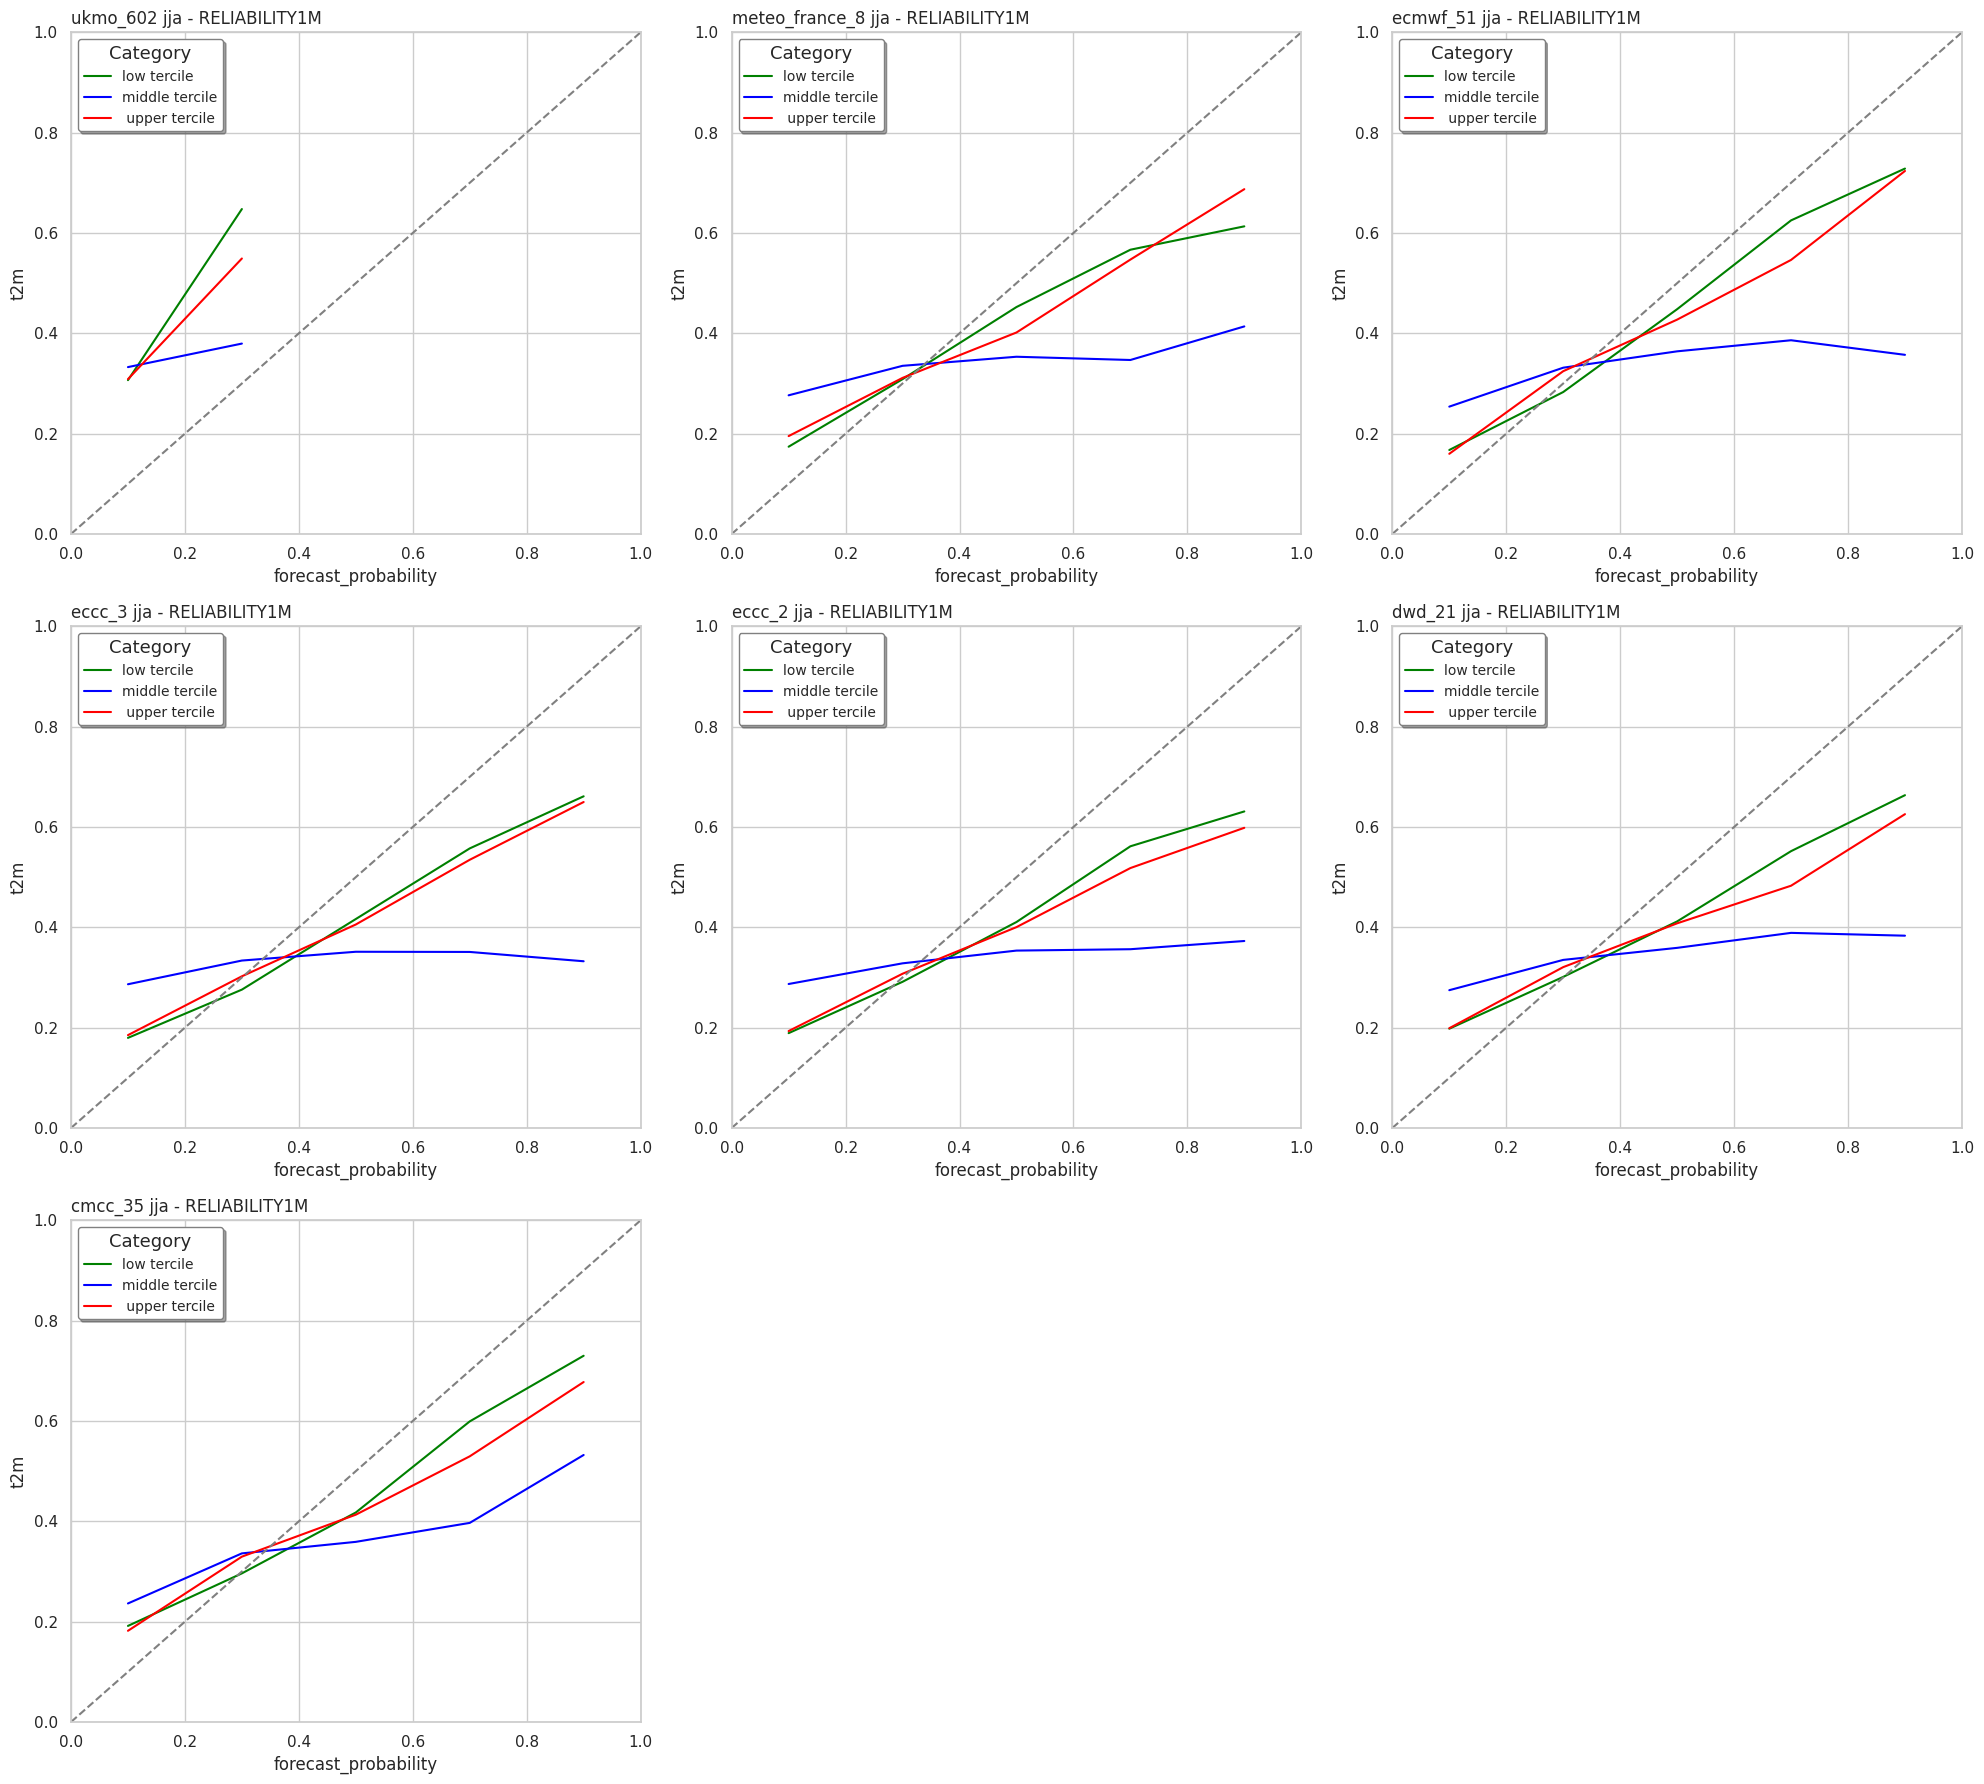

In [58]:
def plot_rela(aggr,period):

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))

    axes = axes.flatten()

    for i in range(n_files):

        metric="rela"

        center = available_files[i]

        rela=load_data_proba(available_files[i], aggr, metric,period)

        df = rela.mean(dim=["lon", "lat", "forecastMonth"], skipna=True).to_dataframe().reset_index()

        df.replace([-np.inf,np.Inf],np.nan,inplace=True)

        df["category"] = df["category"].map({0: "low tercile", 1: "middle tercile", 2: " upper tercile"})

        thisrela = df

        origin_labels = {"institution": center}

        tit_line1 = '{institution} '.format(**origin_labels) + f'{period}'

        tit_line2_base = 'RELIABILITY'

        if aggr == '1m':

            tit_line2 = tit_line2_base + '1M'

        elif aggr == '3m':

            tit_line2 = tit_line2_base + '3M'

        else:

            raise ValueError(f'Unexpected aggregation {aggr}')

        sns.lineplot(data=thisrela, x="forecast_probability",palette=["green", "blue", "red"], y="t2m", hue="category", ax=axes[i])

        sns.set_theme(style="whitegrid")  

        sns.set_context("notebook") 

        axes[i].plot([0, 1], [0, 1], transform=axes[i].transAxes, color='gray', linestyle='--')

        axes[i].set_title(f'{tit_line1} - {tit_line2}', loc='left')

        axes[i].legend(

            title="Category",   

            title_fontsize='13',

            loc='upper left',  

            fontsize='10',  

            frameon=True,   

            shadow=True,    

            facecolor='white', 

            edgecolor='gray'   

        )

        axes[i].set_xlim([0,1])

        axes[i].set_ylim([0,1])

    for j in range(n_files, len(axes)):

        fig.delaxes(axes[j])

    plt.tight_layout()

    plt.xlim([0,1])

    plt.ylim([0,1])

    # plt.savefig(f'/home/mohamed/EHTPIII/MODELISATION/output/plots/rela/rela_diagram_{period}', dpi=300)

    plt.show()


widgets.interactive(plot_rela,period=period_dropdown , aggr=aggr_droptown)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

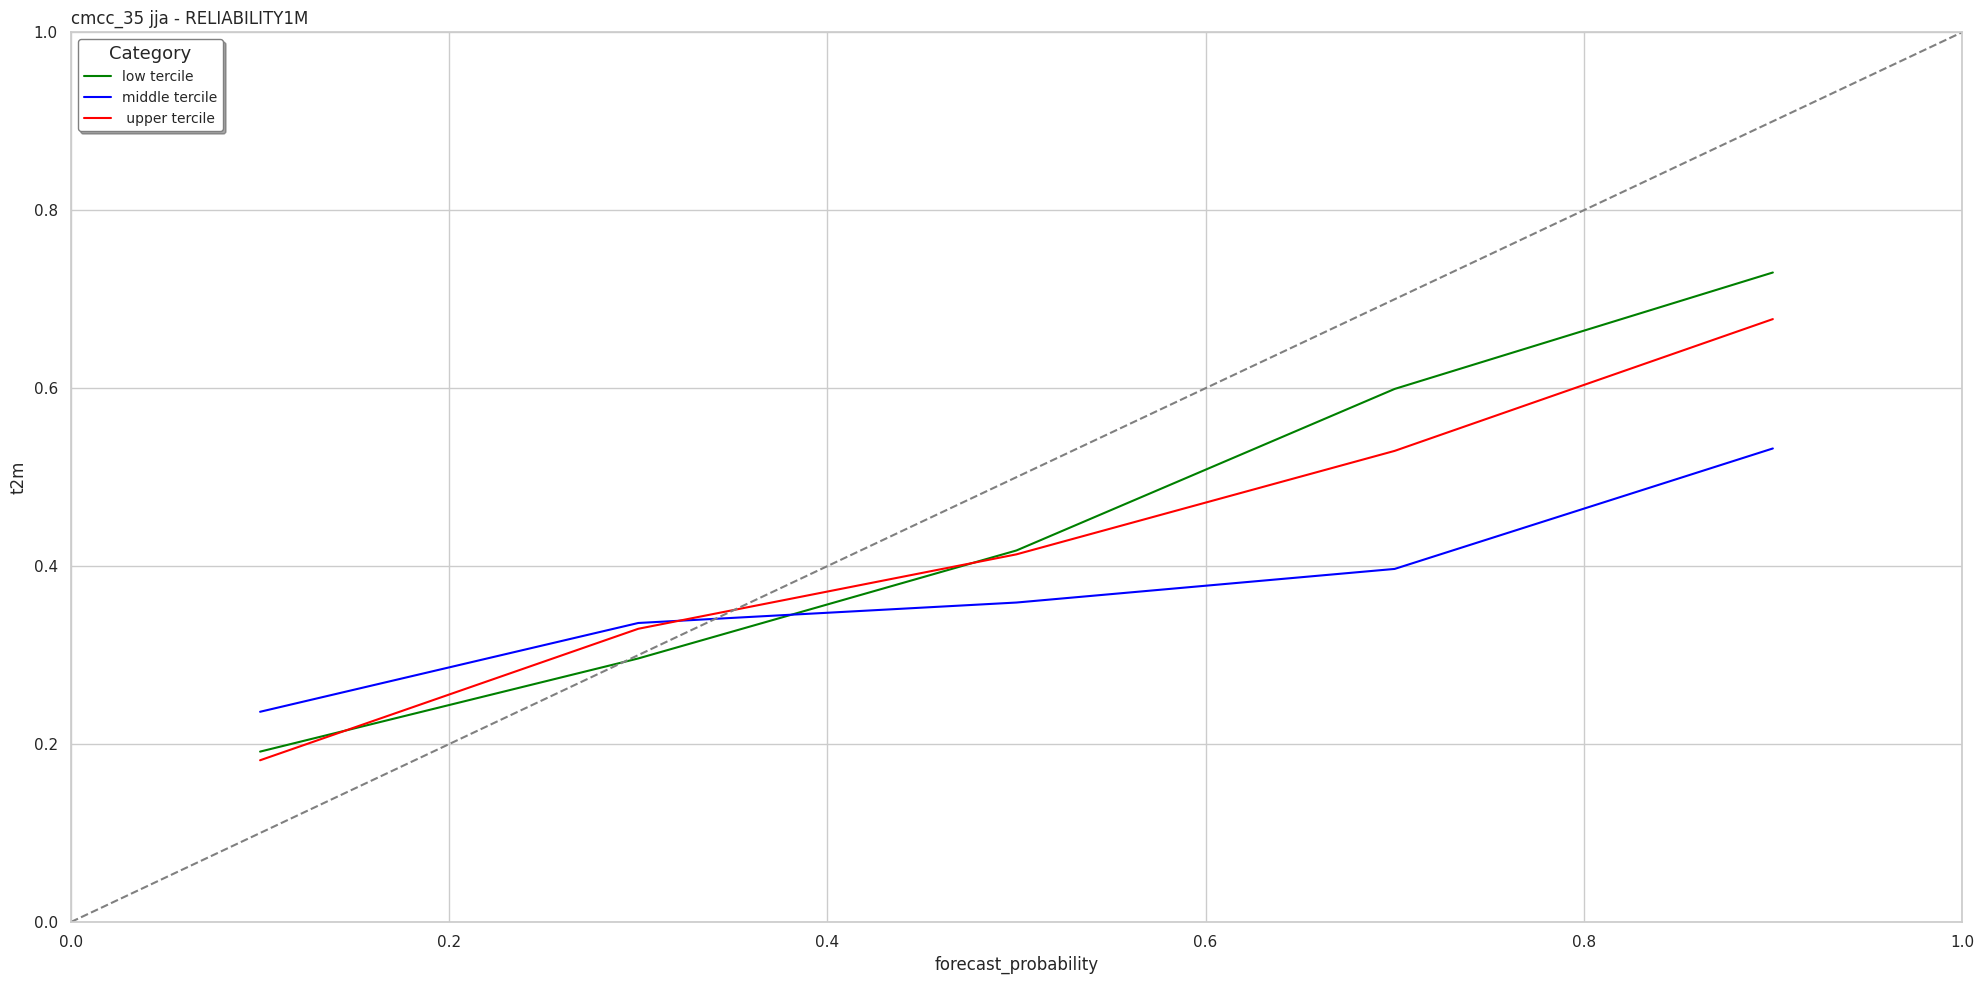

In [57]:
def plot_rela(center,aggr,period):

    

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols



    fig, axes = plt.subplots(figsize=(20, 10 ))



    # rela = xr.open_dataset(f'{SCOREDIR}/scores/{center}{details}.{aggr}.rela.nc')

    metric="rela"

    rela=load_data_proba(center, aggr, metric,period)

    

    df = rela.mean(dim=["lon", "lat", "forecastMonth"], skipna=True).to_dataframe().reset_index()



    df["category"] = df["category"].map({0: "low tercile", 1: "middle tercile", 2: " upper tercile"})



    thisrela = df

    origin_labels = {"institution": center}

    

    tit_line1 = '{institution} '.format(**origin_labels) +f'{period}'

    tit_line2_base = 'RELIABILITY'



    if aggr == '1m':

        tit_line2 = tit_line2_base + '1M'

    elif aggr == '3m':

        tit_line2 = tit_line2_base + '3M'

    else:

        raise ValueError(f'Unexpected aggregation {aggr}')



    sns.lineplot(data=thisrela, x="forecast_probability",palette=["green", "blue", "red"], y="t2m", hue="category", ax=axes)

    sns.set_theme(style="whitegrid")  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'

    sns.set_context("notebook")  # Options: 'paper', 'notebook', 'talk', 'poster'

# Blues , Greens , Reds , 



    axes.plot([0, 1], [0, 1], transform=axes.transAxes, color='gray', linestyle='--')



    # Set the title for each plot

    axes.set_title(f'{tit_line1} - {tit_line2}', loc='left')





    axes.legend(

        title="Category",   # Legend title

        title_fontsize='13', # Legend title font size

        loc='upper left',   # Position of the legend

        fontsize='10',      # Font size of legend labels

        frameon=True,       # Add a frame around the legend

        shadow=True,        # Optional shadow

        facecolor='white',  # Background color of the legend box

        edgecolor='gray'    # Border color

    )

    plt.xlim([0,1])

    plt.ylim([0,1])



    plt.tight_layout()

    # plt.savefig(f'/home/mohamed/EHTPIII/MODELISATION/output/plots/{metric}/{tit_line1}_{tit_line2}', dpi=300)

    plt.show()


widgets.interactive(plot_rela, period=period_dropdown,aggr=aggr_droptown,center=file_droptown)